In [1]:
from PIL import Image
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

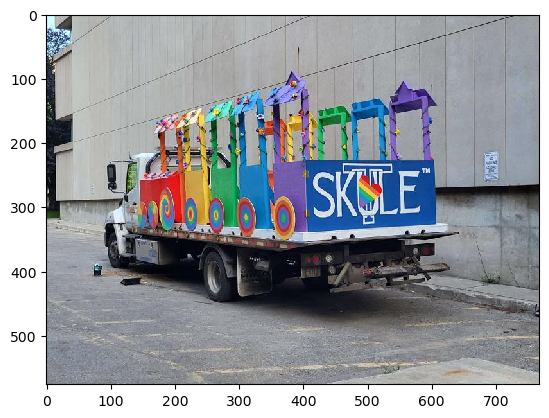

In [2]:
img = np.array(Image.open('img/img01.jpg').convert("RGB")) / 255.0

plt.imshow(img)
plt.show()

In [3]:
replaces = [
    ((0.7, 0.15, 0.15), (0.1, 0.3, 0.6), 1.0),
    ((0.1, 0.3, 0.6), (0.7, 0.2, 0.2), 1.0),
]
fixed = [
    ((0.65, 0.65, 0.65), 1.0),
    ((0.0, 0.0, 0.05), 1.0),
    ((0.2, 0.2, 0.2), 1.0),
    ((0.8, 1.0, 1.0), 0.5),
    ((0.8, 0.6, 0.3), 0.5),
    ((0.45, 0.35, 0.65), 0.5),
    ((0.2, 0.65, 0.4), 0.5),
    ((0.1, 0.5, 0.7), 0.5),
]
for c in fixed:
    replaces.append((c[0], c[0], c[1]))

Model: $f(x)=\sigma(Ax+b)$, where $\sigma(x)=\frac{1}{1+e^{-x}}$ is sigmoid

Cost: given a list of colors $(a,b)$, $f(a)\sim f(b)$

Regularization: $A\sim4I$, $b\sim-2$

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.32255953264093074
        x: [-9.566e-01  9.072e-02  5.322e+00  1.367e+00  3.663e+00
            -5.739e-01  3.651e+00 -1.429e-01  9.484e-01 -2.278e+00
            -2.278e+00 -2.278e+00]
      nit: 214
      jac: [-7.926e-04  2.646e-03  7.894e-03  3.417e-03  5.523e-03
             8.769e-03  2.764e-03  4.154e-03  6.325e-03  1.289e-02
             1.324e-02  6.556e-03]
 hess_inv: [[ 2.369e+02 -3.910e+02 ... -1.468e+00 -1.251e+00]
            [-3.910e+02  6.451e+02 ...  2.422e+00  2.064e+00]
            ...
            [-1.468e+00  2.422e+00 ...  9.616e-03  8.228e-03]
            [-1.251e+00  2.064e+00 ...  8.228e-03  7.119e-03]]
     nfev: 4171
     njev: 320
[[-0.9565827   0.09072401  5.32215626]
 [ 1.36733952  3.66283316 -0.57387194]
 [ 3.65079069 -0.14292004  0.9484301 ]]
[-2.27755495 -2.27755494 -2.27755499]


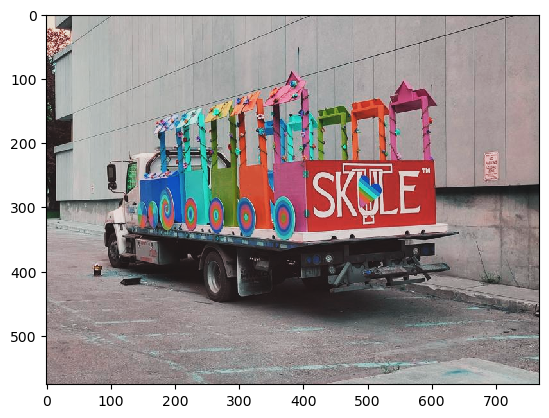

In [4]:
def model(x, A, b):
    x = np.array(x)
    y = A.dot(x) + b[:, np.newaxis]
    return 1.0 / (1.0+np.exp(-y))

def cost(replaces, params):
    assert(len(params) == 12)
    A = params[0:9].reshape((3, 3))
    b = params[9:12].reshape(3)
    regA = np.mean((A-4*np.eye(3))**2)
    regb = np.mean((b+2)**2)
    c = np.sum([c[2]*np.linalg.norm(model(c[0], A, b)-c[1]) for c in replaces]) / \
        np.sum([c[2] for c in replaces])
    return 0.0001*regA + 0.0001*regb + c

def find_params(replaces):
    initial_guess = np.array([4, 0, 0, 0, 4, 0, 0, 0, 4, -2, -2, -2])
    # initial_guess = np.zeros(12)
    res = scipy.optimize.minimize(
        lambda param: cost(replaces, param),
        initial_guess)
    print(res)
    params = res.x
    A = params[0:9].reshape((3, 3))
    b = params[9:12].reshape(3)
    return A, b

A, b = find_params(replaces)
print(A)
print(b)

imgp = np.einsum('ijk->kij', img)
img1 = model(imgp.reshape((3, -1)), A, b).reshape(imgp.shape)
img1 = np.einsum('kij->ijk', img1)
plt.imshow(img1)
plt.show()

Model: $f(x)=\sigma(A_2\sigma(A_1x+b_1)+b_2)$

Cost: given a list of colors $(a,b)$, $f(a)\sim f(b)$

Regularization: $A\sim0$, $b\sim0$, $A\vec{1}+2b\sim0$

suffers from local minima

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.19868993954096104
        x: [-4.742e-02 -3.126e-02 ... -2.469e+03 -2.301e+03]
      nit: 455
      jac: [-6.306e+00 -6.659e+00 ... -4.368e-02 -1.128e-02]
 hess_inv: [[ 6.924e-05  1.245e-03 ... -7.897e-04 -5.277e-04]
            [ 1.232e-03  3.115e-01 ... -7.043e-02 -7.330e-02]
            ...
            [-8.156e-04 -7.242e-02 ...  2.374e+00  1.771e+00]
            [-5.354e-04 -7.430e-02 ...  1.771e+00  2.101e+00]]
     nfev: 16685
     njev: 667
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.13818877328695794
        x: [ 1.587e+00 -5.128e-01 ... -5.546e+00 -7.026e+00]
      nit: 1901
      jac: [-2.531e-02 -1.417e-03 ... -2.014e-02 -1.308e-02]
 hess_inv: [[ 7.942e+00 -4.494e+00 ...  4.013e+01  3.758e+01]
            [-4.494e+00  6.112e+00 ... -2.072e+01 -1.994e+01]
            ...
            [ 4.013e

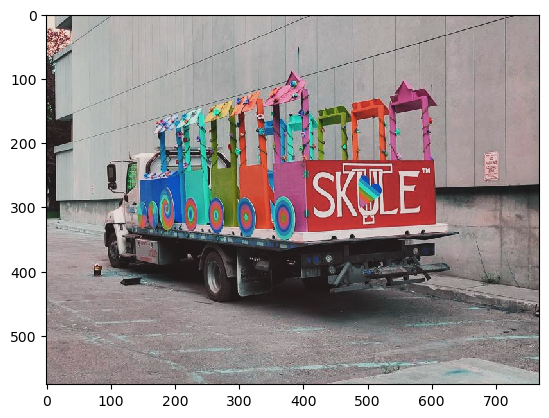

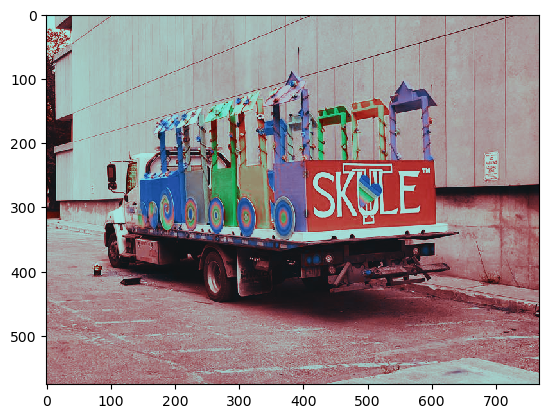

In [5]:
K = 3

def model(x, A1, b1, A2, b2):
    x = np.array(x)
    if len(x.shape) > 1:
        b1 = b1[:, np.newaxis]
        b2 = b2[:, np.newaxis]
    y1 = A1.dot(x) + 1.0*b1
    y1 = 1.0 / (1.0+np.exp(-y1))
    # y1 = 0.5 + 0.25*y1
    y2 = A2.dot(y1) + 1.0*b2
    return 1.0 / (1.0+np.exp(-y2))
    return y2

def decode_params(params):
    assert(len(params) == 3*K+K+K*3+3)
    A1 = params[0:3*K].reshape((K, 3))
    b1 = params[3*K:4*K].reshape(K)
    A2 = params[4*K:7*K].reshape((3, K))
    b2 = params[7*K:7*K+3].reshape(3)
    return (A1, b1, A2, b2)

def cost1(replaces, params):
    params = decode_params(params)
    A1, b1, A2, b2 = params
    reg = np.mean(A1**2) + np.mean(b1**2)
    c = np.sum([c[2]*np.linalg.norm(model(c[0],*params)-c[1]) for c in replaces]) / \
        np.sum([c[2] for c in replaces])
    return 1.0*reg + c

def cost2(replaces, params):
    params = decode_params(params)
    A1, b1, A2, b2 = params
    reg = [
        np.mean(A1**2), np.mean(b1**2),
        np.mean(A2**2), np.mean(b2**2),
        0.5*np.mean((A1.dot(np.ones(3))-2*b1)**2),
        # 0.5*np.mean((A2.dot(np.ones(K))-2*b2)**2)
    ]
    c = np.sum([c[2]*np.linalg.norm(model(c[0],*params)-c[1]) for c in replaces]) / \
        np.sum([c[2] for c in replaces])
    return 0.001*np.mean(reg) + c

def find_params(replaces):
    params = []
    # initial_guess = np.zeros(3*K+K+K*3+3)
    initial_guess = np.array([4, 0, 0, 0, 4, 0, 0, 0, 4, -2, -2, -2]*2)  # K=3
    res = scipy.optimize.minimize(
        lambda param: cost1(replaces, param),
        initial_guess)
    print(res)
    params.append(decode_params(res.x))
    res = scipy.optimize.minimize(
        lambda param: cost2(replaces, param),
        initial_guess)
    print(res)
    params.append(decode_params(res.x))
    return params

params = find_params(replaces)

for param in params:
    imgp = np.einsum('ijk->kij', img)
    img1 = model(imgp.reshape((3, -1)), *param).reshape(imgp.shape)
    img1 = np.einsum('kij->ijk', img1)
    plt.imshow(img1)
    plt.show()

https://andersource.dev/2021/06/12/image-color-replacement.html

latent space?

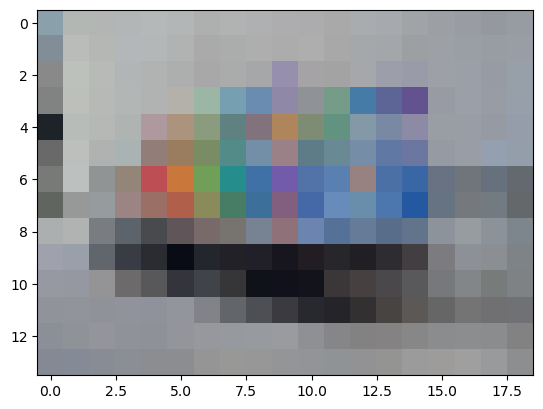

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.011250613969070417
        x: [ 5.103e-03  1.186e-01 ... -7.620e+02 -8.767e+02]
      nit: 772
      jac: [-1.592e+00 -1.575e+00 ... -7.830e-03 -1.362e-02]
 hess_inv: [[ 1.775e+01 -6.292e+00 ...  1.289e+04  1.734e+04]
            [-6.292e+00  6.523e+00 ... -5.752e+03 -7.738e+03]
            ...
            [ 1.289e+04 -5.752e+03 ...  1.767e+07  2.384e+07]
            [ 1.734e+04 -7.738e+03 ...  2.384e+07  3.215e+07]]
     nfev: 41642
     njev: 905


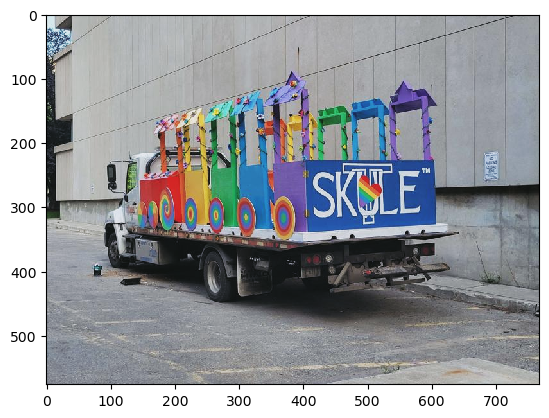

In [6]:
K = 6

def model(x, A1, b1, A2, b2):
    x = np.array(x)
    if len(x.shape) > 1:
        b1 = b1[:, np.newaxis]
        b2 = b2[:, np.newaxis]
    y1 = A1.dot(x) + 1.0*b1
    y1 = 1.0 / (1.0+np.exp(-y1))
    y2 = A2.dot(y1) + 1.0*b2
    return 1.0 / (1.0+np.exp(-y2))

def decode_params(params):
    assert(len(params) == 3*K+K+K*3+3)
    A1 = params[0:3*K].reshape((K, 3))
    b1 = params[3*K:4*K].reshape(K)
    A2 = params[4*K:7*K].reshape((3, K))
    b2 = params[7*K:7*K+3].reshape(3)
    return (A1, b1, A2, b2)

def cost1(pixels, params):
    A1, b1, A2, b2 = decode_params(params)
    y1 = A1.dot(pixels) + b1[:, np.newaxis]
    y1 = 1.0 / (1.0+np.exp(-y1))
    y2 = A2.dot(y1) + b2[:, np.newaxis]
    y2 = 1.0 / (1.0+np.exp(-y2))

    # small difference
    diff = np.mean(np.abs(y2-pixels))
    # diff = np.mean((y2-pixels)**2)

    # small A1 and b1
    reg = np.mean(A1**2) + np.mean(b1**2)

    # large latent channel difference
    latentdiff = 0.0
    if K > 1:
        for i in range(K):
            for j in range(i):
                latentdiff += np.mean((y1[j]-y1[i])**4)
        latentdiff /= K*(K-1)/2
    return 0.1*reg + 2.0*diff - 0.1*latentdiff


# reduce image resolution
ts = 40
rs = round(np.prod(img.shape[:2])**0.5/ts+0.5)
imgr = img[0:ts*(img.shape[0]//ts), 0:ts*(img.shape[1]//ts), :]
imgr = imgr.reshape((img.shape[0]//ts, ts, img.shape[1]//ts, ts, 3)).mean((1, 3))
plt.imshow(imgr)
plt.show()

# fit initial image, should suffer less from local minima
# to-do: Gauss-Newton / LM with gradient
pixels = np.einsum('ijk->kij', imgr).reshape((3, -1))
initial_guess = np.zeros(3*K+K+K*3+3)
res = scipy.optimize.minimize(
    lambda param: cost1(pixels, param),
    initial_guess)
print(res)
params = decode_params(res.x)

# plot
imgp = np.einsum('ijk->kij', img)
img1 = model(imgp.reshape((3, -1)), *params).reshape(imgp.shape)
img1 = np.einsum('kij->ijk', img1)
plt.imshow(img1)
plt.show()

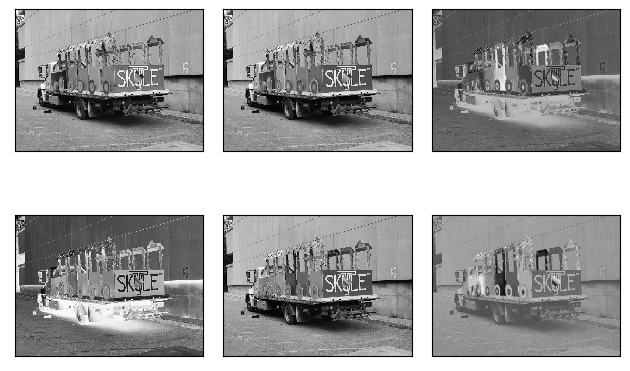

In [7]:
# plot latent representation, make sure they are representative
grid_nx = int(np.ceil(K**0.5))
grid_ny = int(np.ceil(K/grid_nx))
fig, axs = plt.subplots(grid_ny, grid_nx)

x = imgp.reshape((3, -1))
y = params[0].dot(x) + params[1][:, np.newaxis]
y = 1.0 / (1.0+np.exp(-y))
img1 = y.reshape([K, *imgp.shape[1:]])

for i in range(K):
    ax = axs[i//grid_nx, i%grid_nx] if K > 2 else axs[i]
    ax.imshow(img1[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.20639781306497743
        x: [ 2.420e+01  3.830e+00 ... -6.573e-01 -3.145e-01]
      nit: 250
      jac: [ 1.279e-02  1.332e-02 ...  2.159e-02 -9.267e-03]
 hess_inv: [[ 1.425e+04  3.769e+03 ... -1.218e+02 -2.334e+03]
            [ 3.769e+03  2.679e+03 ... -5.201e+01 -1.568e+03]
            ...
            [-1.218e+02 -5.201e+01 ...  1.856e+00  3.120e+01]
            [-2.334e+03 -1.568e+03 ...  3.120e+01  9.212e+02]]
     nfev: 8856
     njev: 402


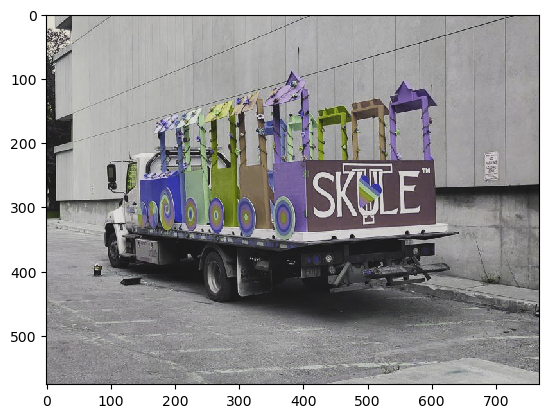

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.1106368912320124
        x: [ 2.938e+00 -3.149e+00 ... -2.908e-01  7.731e-02]
      nit: 2148
      jac: [ 1.083e-03 -5.076e-03 ...  2.387e-02 -4.411e-03]
 hess_inv: [[ 3.084e+00 -1.732e+00 ... -1.373e+01 -9.647e+00]
            [-1.732e+00  1.199e+00 ...  7.464e+00  5.250e+00]
            ...
            [-1.373e+01  7.464e+00 ...  6.244e+01  4.404e+01]
            [-9.647e+00  5.250e+00 ...  4.404e+01  3.136e+01]]
     nfev: 111792
     njev: 2430


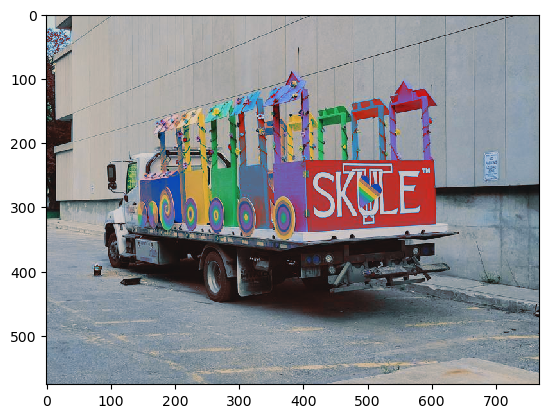

In [8]:
def cost21(replaces, params):
    params = decode_params(params)
    A1, b1, A2, b2 = params
    reg = [
        # np.mean(A1**2), np.mean(b1**2),
        np.mean(A2**2), np.mean(b2**2),
        # 0.5*np.mean((A1.dot(np.ones(3))-2*b1)**2),
        0.5*np.mean((A2.dot(np.ones(K))-2*b2)**2)
    ]
    c = np.sum([c[2]*np.linalg.norm(model(c[0],*params)-c[1]) for c in replaces]) / \
        np.sum([c[2] for c in replaces])
    return 0.0001*np.mean(reg) + c

def cost22(replaces, params):
    params = decode_params(params)
    A1, b1, A2, b2 = params
    reg = [
        np.mean(A1**2), np.mean(b1**2),
        np.mean(A2**2), np.mean(b2**2),
        # 0.5*np.mean((A1.dot(np.ones(3))-2*b1)**2),
        # 0.5*np.mean((A2.dot(np.ones(K))-2*b2)**2)
    ]
    c = np.sum([c[2]*np.linalg.norm(model(c[0],*params)-c[1]) for c in replaces]) / \
        np.sum([c[2] for c in replaces])
    return 0.01*np.mean(reg) + c

initial_guess = np.zeros(K*3+3)
params01 = np.concatenate((params[0].flatten(), params[1]))
res = scipy.optimize.minimize(
    lambda param: cost21(replaces, np.concatenate((params01, param))),
    initial_guess)
print(res)
params1 = np.concatenate((params01, res.x))

imgp = np.einsum('ijk->kij', img)
img1 = model(imgp.reshape((3, -1)), *decode_params(params1)).reshape(imgp.shape)
img1 = np.einsum('kij->ijk', img1)
plt.imshow(img1)
plt.show()

res = scipy.optimize.minimize(
    lambda param: cost22(replaces, param),
    params1)
print(res)
params2 = res.x

img1 = model(imgp.reshape((3, -1)), *decode_params(params2)).reshape(imgp.shape)
img1 = np.einsum('kij->ijk', img1)
plt.imshow(img1)
plt.show()
